# DSO 522: Applied Time Series Analysis for Forecasting

## Week 14: Advanced Deep Learning Methods for Forecasting (Part II)

In [83]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# 1. Introduction to RNNs

Recurrent Neural Networks (RNNs) are a class of neural networks designed to process sequential data. They are particularly well-suited for time series forecasting because they explicitly model temporal dependencies by maintaining a hidden state that captures information from previous time steps.

In traditional feedforward neural networks, each input is processed independently. However, RNNs introduce recurrence, allowing information to persist across steps, which is crucial for modeling patterns in time series data.

---



## How RNNs Work

### Architecture
An RNN consists of the following components:
- **Input layer**: Processes the input sequence at each time step.
- **Hidden state**: Maintains a memory of past inputs, enabling the network to capture temporal dependencies.
- **Output layer**: Generates predictions based on the current hidden state.

### Mathematical Formulation
At each time step $t$, the RNN updates its hidden state $h_t$,
$$
h_t = \sigma(W_{hh} h_{t-1} + W_{xh} x_t + b_h)
$$
and generates an output $y_t$,
$$
y_t = W_{hy} h_t + b_y
$$
Where:
- $x_t$ is the input at time step $t$.
- $h_t$ is the hidden state at time $t$, which depends on both the current input $x_t$ and the previous hidden state $h_{t-1}$.
- $\sigma$ is the activation function (e.g., tanh or ReLU).
- $W_{hh}, W_{xh}, W_{hy}$ are weight matrices.
- $b_h, b_y$ are bias terms.

This recurrence allows RNNs to model dependencies over time.

---

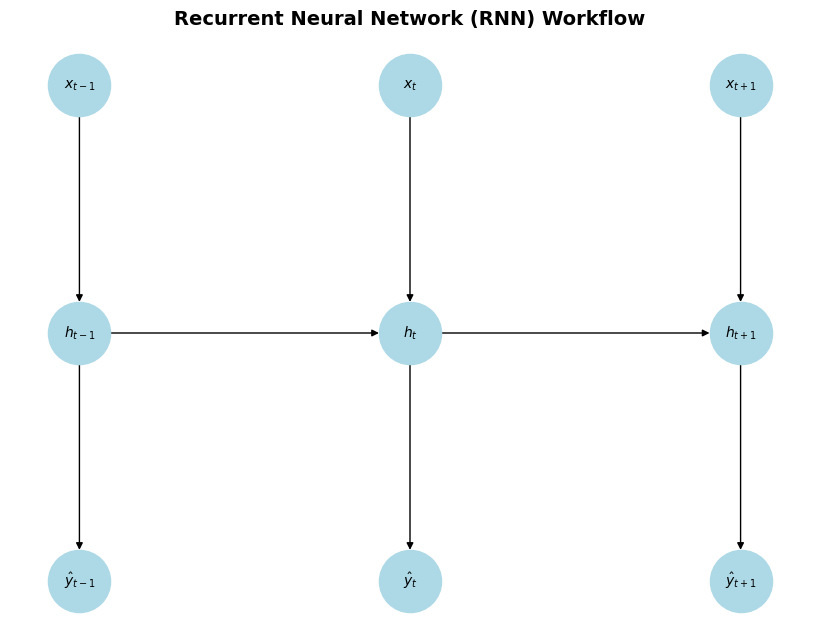

In [84]:
import matplotlib.pyplot as plt
import networkx as nx

# Create the graph
G = nx.DiGraph()

# Define positions for nodes
pos = {
    "$x_{t-1}$": (0, 2),
    "$x_t$": (1, 2),
    "$x_{t+1}$": (2, 2),
    "$h_{t-1}$": (0, 1),
    "$h_t$": (1, 1),
    "$h_{t+1}$": (2, 1),
    "$\\hat{y}_{t-1}$": (0, 0),
    "$\\hat{y}_t$": (1, 0),
    "$\\hat{y}_{t+1}$": (2, 0),
}

# Add nodes
nodes = list(pos.keys())
G.add_nodes_from(nodes)

# Add edges for RNN flow
edges = [
    ("$x_{t-1}$", "$h_{t-1}$"),
    ("$x_t$", "$h_t$"),
    ("$x_{t+1}$", "$h_{t+1}$"),
    ("$h_{t-1}$", "$h_t$"),
    ("$h_t$", "$h_{t+1}$"),
    ("$h_{t-1}$", "$\\hat{y}_{t-1}$"),
    ("$h_t$", "$\\hat{y}_t$"),
    ("$h_{t+1}$", "$\\hat{y}_{t+1}$"),
]

G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2000,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
)
plt.title("Recurrent Neural Network (RNN) Workflow", fontsize=14, fontweight="bold")
plt.show()


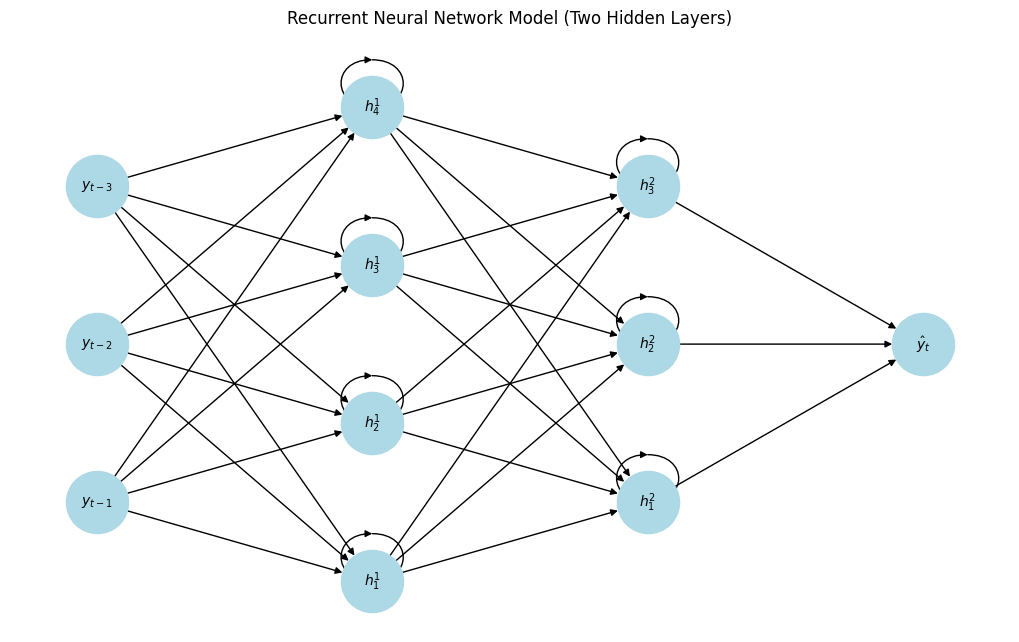

In [85]:
# Generate a detailed diagram for a neural network
import matplotlib.pyplot as plt
import networkx as nx

def draw_rnn():
    """
    Draw a diagram for a Recurrent Neural Network Model with two hidden layers.
    """
    G = nx.DiGraph()

    # Input nodes (past time steps)
    input_nodes = [f"$y_{{t-{i}}}$" for i in range(1, 4)]  # y_{t-1}, y_{t-2}, y_{t-3}
    for i, node in enumerate(input_nodes):
        G.add_node(node, pos=(0, i))

    # First hidden layer
    hidden_layer1 = [f"$h^1_{{{i+1}}}$" for i in range(4)]  # Hidden layer 1 nodes
    for i, node in enumerate(hidden_layer1):
        G.add_node(node, pos=(1, i - 0.5))

    # Second hidden layer
    hidden_layer2 = [f"$h^2_{{{i+1}}}$" for i in range(3)]  # Hidden layer 2 nodes
    for i, node in enumerate(hidden_layer2):
        G.add_node(node, pos=(2, i - 0))

    # Output node
    output_node = "$\hat{y}_t$"
    G.add_node(output_node, pos=(3, 1))

    # Add edges: Input -> First Hidden Layer
    for input_node in input_nodes:
        for hidden_node in hidden_layer1:
            G.add_edge(input_node, hidden_node)

    # Add edges: First Hidden Layer -> Second Hidden Layer
    for hidden1_node in hidden_layer1:
        for hidden2_node in hidden_layer2:
            G.add_edge(hidden1_node, hidden2_node)

    # Add self-edges: First Hidden Layer -> First Hidden Layer
    for hidden1_node in hidden_layer1:
        G.add_edge(hidden1_node, hidden1_node)

    # Add edges: Second Hidden Layer -> Output
    for hidden2_node in hidden_layer2:
        G.add_edge(hidden2_node, output_node)

    # Add self-edges: Second Hidden Layer -> Second Hidden Layer
    for hidden2_node in hidden_layer2:
        G.add_edge(hidden2_node, hidden2_node)

    # Draw the network
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10)
    plt.title("Recurrent Neural Network Model (Two Hidden Layers)")
    plt.show()

# Draw the recurrent neural network diagram
draw_rnn()

## Understanding Lagged Inputs in RNNs

In Recurrent Neural Networks (RNNs), the input to the model at each time step consists of **lagged values** of the target variable $Y$. For example, to predict $Y_t$, the inputs might include $x_{t-1}$, $x_{t-2}$, and $x_{t-3}$, where $x_{t-i}$ represents the value of $Y$ at time $t-i$.

This approach is consistent with what we explored in feedforward models, where past observations of the series act as the primary predictors for future values. However, RNNs improve on this by introducing recurrence, which allows the model to maintain a **hidden state** that carries information across time steps.

### Key Differences from Feedforward Models
- **Memory of Past States**: Instead of relying solely on fixed lagged inputs, RNNs use hidden states $h_t$, which dynamically encode both the current input and the sequence of past information.
- **Recurrent Connections**: Hidden states have self-loops, enabling the model to "remember" patterns and dependencies across arbitrarily long sequences.

### RNN Architecture Overview
1. **Inputs**: Lagged values $x_{t-1}$, $x_{t-2}$, $x_{t-3}$ feed into the RNN.
2. **Hidden States**: Each hidden state $h_t$ is updated based on the current input and the previous hidden state ($h_{t-1}$).
3. **Outputs**: Predictions $\hat{y}_{t-1}$, $\hat{y}_{t-2}$, $\hat{y}_{t-3}$ are generated from the corresponding hidden states.

This combination of lagged inputs and recurrent processing allows RNNs to learn both short-term and long-term temporal dependencies, making them more versatile for time series forecasting tasks compared to feedforward networks.


## Initialization in RNNs

### Initialization

When training or using an RNN for forecasting, **initialization** refers to setting up the initial conditions for the network. The key components that need to be initialized are:

**Initial Hidden State**
- The hidden state $h_0$ is required to start the recurrent process since it represents the "memory" of the network.
- Typical initialization strategies:
  - **Zero Initialization**: Start with $h_0 = 0$. This is simple and ensures consistency across experiments.
  - **Random Initialization**: Initialize $h_0$ with small random values (e.g., from a uniform or normal distribution). This adds variability but might make training less stable.
  - **Learned Initialization**: Treat $h_0$ as a parameter to be learned during training.

The choice of initialization can impact the model's convergence during training and its forecasting accuracy.

**Weights and Biases**
- The weight matrices ($W_{xh}$, $W_{hh}$, $W_{hy}$) and biases ($b_h$, $b_y$) are typically initialized using:
  - Random small values (e.g., Gaussian distribution with mean 0 and small variance).
  - Specialized initialization methods like Xavier or He initialization, which ensure stable gradients during backpropagation.

**Input Normalization**
- Inputs (e.g., lagged values $x_{t-i}$) are often normalized to a standard range (e.g., [0, 1] or mean 0, variance 1). This helps the RNN converge faster and perform better.

---



## Forecasting with RNNs

Once the RNN is trained, forecasting involves predicting future values of the time series based on past observations. There are two main approaches:

### 1. **One-Step-Ahead Forecasting**
- The RNN predicts the next time step $y_t$ based on lagged inputs $y_{t-1}, y_{t-2}, \dots, y_{t-L}$.
- Steps:
  1. Provide the lagged inputs to the RNN.
  2. The RNN processes these inputs through its hidden layers and produces an output $\hat{y}_t$.
  3. Repeat the process for each time step, shifting the input window forward.

This method is simple and reliable because the lagged inputs are actual observed values.

### 2. **Multi-Step Forecasting**
- The RNN predicts multiple future time steps, e.g., $\hat{y}_{t+1}, \hat{y}_{t+2}, \dots, \hat{y}_{t+h}$.
- Two approaches:
  - **Iterative Forecasting**:
    As in the previous notes on feedforward neural networks.
    - **Pros**: Simpler implementation.
    - **Cons**: Errors accumulate over time because predictions are used as inputs.
  - **Direct Forecasting**:
    - Train separate models to predict each horizon directly.
    - **Pros**: Reduces error accumulation.
    - **Cons**: Requires more models and training complexity.

### 3. **Sequence-to-Sequence Forecasting**
- For longer horizons, RNNs can be extended to Sequence-to-Sequence (Seq2Seq) models, which predict a sequence of future values directly from a sequence of inputs.
- Example: Predict $\hat{y}_{t+1}, \hat{y}_{t+2}, \dots, \hat{y}_{t+h}$ based on $x_{t}, x_{t-1}, \dots$ in one step.
- Seq2Seq models often use advanced architectures like LSTMs or GRUs for better performance.

---

## Variants of RNNs

Several advanced RNN architectures address the challenges of exploding and vanishing gradients:

1. **Long Short-Term Memory (LSTM)**:
   - Introduces gating mechanisms (input, forget, and output gates) to control the flow of information.
   - Capable of learning long-term dependencies by selectively remembering or forgetting information.

2. **Gated Recurrent Unit (GRU)**:
   - A simplified version of LSTM with fewer gates (update and reset gates).
   - Offers similar performance to LSTMs while being computationally more efficient.

Both LSTMs and GRUs are widely used in time series forecasting tasks for their ability to model long-term temporal relationships.

## Challenges with RNNs

While RNNs are powerful for sequential modeling, they face the following challenges:
- **Exploding gradients**: During training, gradients can grow exponentially, causing numerical instability.
- **Vanishing gradients**: Gradients can shrink to near-zero, making it difficult for the model to learn long-term dependencies.

These issues limit the ability of vanilla RNNs to capture dependencies over long sequences.

---



# Hands-On Example

## Simulating a time series data set

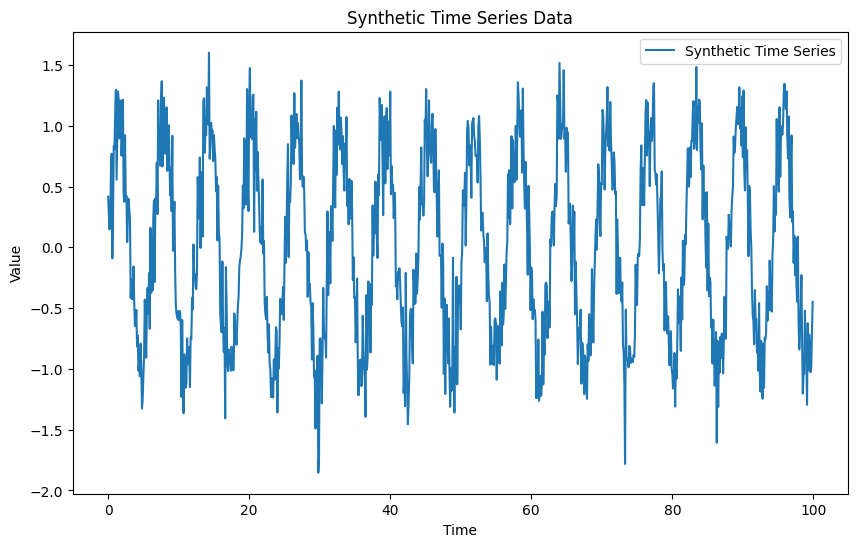

In [86]:
# Generate a synthetic time series dataset
np.random.seed(2024)
time = np.arange(0, 100, 0.1)
data = np.sin(time) + 0.25 * np.random.normal(size=len(time))

# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(time, data, label="Synthetic Time Series")
plt.title("Synthetic Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

## Preparing the Data for Neural Networks

In [87]:
# Define a function to prepare data in sliding window format
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

SEQ_LENGTH = 20
sequences, targets = create_sequences(data, SEQ_LENGTH)

In [88]:
# Sequentially split the data into training and testing sets
def split_time_series(data, targets, test_size=0.2):
    """
    Splits time series data into training and testing sets while preserving temporal order.

    Args:
        data (ndarray): The input sequences (e.g., lagged predictors).
        targets (ndarray): The target values corresponding to the input sequences.
        test_size (float): Proportion of the data to use for testing (default: 0.2).

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    n_test = int(len(data) * test_size)
    X_train, X_test = data[:-n_test], data[-n_test:]
    y_train, y_test = targets[:-n_test], targets[-n_test:]
    return X_train, X_test, y_train, y_test

# Split into training and testing sets
X_train, X_test, y_train, y_test = split_time_series(sequences, targets, test_size=0.2)
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 784
Testing set size: 196


## Building a Recurrent Neural Network Model

In [89]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Add the last dimension
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [90]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Args:
            input_size: Number of features per time step (e.g., 1 for univariate series).
            hidden_size: Number of hidden units in the RNN.
            num_layers: Number of RNN layers.
            output_size: Number of output features (e.g., 1 for univariate prediction).
        """
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer to map the last hidden state to the output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass through the RNN.
        Args:
            x: Input tensor of shape [batch_size, seq_length, input_size].
            - For univariate input, input_size should be 1 (e.g., [batch_size, seq_length, 1]).
        Returns:
            out: Output tensor of shape [batch_size, output_size].
        """
        batch_size = x.size(0)

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # RNN forward pass
        out, _ = self.rnn(x, h0)

        # Use the hidden state of the last time step for prediction
        out = self.fc(out[:, -1, :])
        return out

In [91]:
# Define model parameters
input_size = 1        # Number of features per time step (e.g., univariate series)
hidden_size = 16      # Number of features in the hidden state
num_layers = 1        # Single RNN layer
output_size = 1       # Predict one value (e.g., next step in the series)

# Instantiate the model
model = RNNModel(input_size, hidden_size, num_layers, output_size)

# Example input: Batch of 32 sequences, each of length SEQ_LENGTH, with 1 feature
example_input = torch.randn(32, SEQ_LENGTH, input_size)  # Shape: [batch_size, seq_length, input_size]
print("Input shape:", example_input.shape)

# Forward pass
output = model(example_input)
print("Output shape:", output.shape)  # Expected: [32, 1] (one output per sequence in the batch)

Input shape: torch.Size([32, 20, 1])
Output shape: torch.Size([32, 1])


In [92]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training the Model

In [93]:
# Train the RNNModel
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(X_batch)

        # Compute loss
        loss = criterion(outputs.squeeze(), y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average loss for the epoch
    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}")


Epoch 1/50, Loss: 0.2275
Epoch 2/50, Loss: 0.1123
Epoch 3/50, Loss: 0.1073
Epoch 4/50, Loss: 0.1056
Epoch 5/50, Loss: 0.1037
Epoch 6/50, Loss: 0.1031
Epoch 7/50, Loss: 0.1010
Epoch 8/50, Loss: 0.0989
Epoch 9/50, Loss: 0.0959
Epoch 10/50, Loss: 0.0894
Epoch 11/50, Loss: 0.0888
Epoch 12/50, Loss: 0.0836
Epoch 13/50, Loss: 0.0829
Epoch 14/50, Loss: 0.0819
Epoch 15/50, Loss: 0.0837
Epoch 16/50, Loss: 0.0805
Epoch 17/50, Loss: 0.0815
Epoch 18/50, Loss: 0.0808
Epoch 19/50, Loss: 0.0807
Epoch 20/50, Loss: 0.0775
Epoch 21/50, Loss: 0.0781
Epoch 22/50, Loss: 0.0790
Epoch 23/50, Loss: 0.0787
Epoch 24/50, Loss: 0.0772
Epoch 25/50, Loss: 0.0773
Epoch 26/50, Loss: 0.0773
Epoch 27/50, Loss: 0.0760
Epoch 28/50, Loss: 0.0772
Epoch 29/50, Loss: 0.0782
Epoch 30/50, Loss: 0.0757
Epoch 31/50, Loss: 0.0757
Epoch 32/50, Loss: 0.0745
Epoch 33/50, Loss: 0.0769
Epoch 34/50, Loss: 0.0772
Epoch 35/50, Loss: 0.0767
Epoch 36/50, Loss: 0.0771
Epoch 37/50, Loss: 0.0762
Epoch 38/50, Loss: 0.0761
Epoch 39/50, Loss: 0.

## Evaluating the Model

In [94]:
def evaluate_model(model, data_loader, criterion):
    """
    Evaluates the model on the provided dataset.

    Args:
        model (nn.Module): The trained neural network model.
        data_loader (DataLoader): DataLoader for the dataset to evaluate (e.g., test set).
        criterion (nn.Module): Loss function to compute the error.

    Returns:
        float: The average loss over the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs.squeeze(), y_batch)  # Compute batch loss
            total_loss += loss.item()  # Accumulate the loss

    average_loss = total_loss / len(data_loader)  # Compute the average loss
    return average_loss

# Evaluate the model on the test set
test_loss = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0623


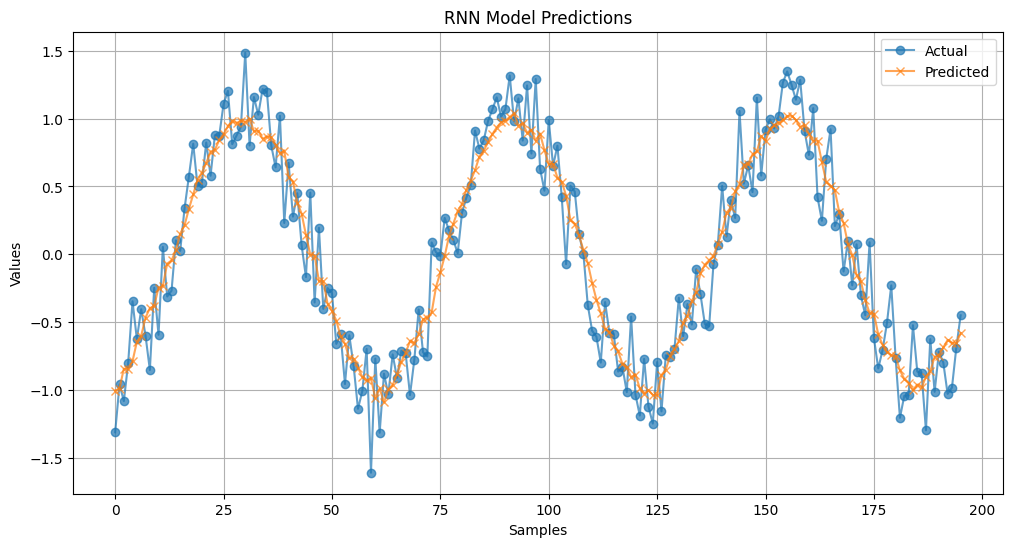

In [95]:
def plot_predictions(model, data_loader, title="Model Predictions"):
    """
    Generates predictions using the model and plots them against actual values.

    Args:
        model (nn.Module): The trained neural network model.
        data_loader (DataLoader): DataLoader containing the test dataset.
        title (str): Title for the plot (default: "Model Predictions").
    """
    model.eval()  # Set the model to evaluation mode
    predictions, actuals = [], []

    with torch.no_grad():  # Disable gradient calculation for inference
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)  # Forward pass
            predictions.extend(outputs.squeeze().tolist())  # Append predictions
            actuals.extend(y_batch.tolist())  # Append actual values

    # Plot the actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label="Actual", linestyle='-', marker='o', alpha=0.7)
    plt.plot(predictions, label="Predicted", linestyle='-', marker='x', alpha=0.7)
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot 1-step-ahead predictions
plot_predictions(model, test_loader, title="RNN Model Predictions")

## Forecasting the Time Series with a Horizon h

In [96]:
def multi_step_forecast(model, initial_sequence, horizon):
    """
    Perform h-step-ahead forecasting using a trained RNN model.

    Args:
        model (nn.Module): The trained RNN model.
        initial_sequence (torch.Tensor): The initial sequence (lagged predictors) for the forecast,
                                         of shape [seq_length].
        horizon (int): The number of steps to forecast.

    Returns:
        list: Forecasted values for the horizon.
    """
    model.eval()  # Set the model to evaluation mode
    forecasted = []  # Store forecasted values

    # Ensure the sequence is 3D: [1, seq_length, input_size]
    current_sequence = initial_sequence.unsqueeze(0).unsqueeze(-1).clone().detach()

    with torch.no_grad():  # Disable gradient calculations
        for _ in range(horizon):
            # Predict the next value
            next_value = model(current_sequence).squeeze().item()
            forecasted.append(next_value)

            # Update the sequence by appending the new prediction and dropping the oldest value
            next_value_tensor = torch.tensor([[next_value]], dtype=torch.float32).to(current_sequence.device)
            current_sequence = torch.cat([current_sequence[:, 1:, :], next_value_tensor.unsqueeze(-1)], dim=1)

    return forecasted

In [97]:
def plot_forecasts(time, data, train_end_idx, test_start_idx, forecasted_values, title="Time Series Forecasting"):
    """
    Plot the original time series data along with the forecasted values.

    Args:
        time (np.ndarray): Array of time indices.
        data (np.ndarray): Original time series data.
        train_end_idx (int): Index marking the end of the training data.
        test_start_idx (int): Index marking the start of the test data.
        forecasted_values (list): Forecasted values for the horizon.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(12, 8))

    # Plot training data
    plt.plot(time[:train_end_idx], data[:train_end_idx], label="Train Data", color="blue", alpha=0.5)

    # Plot actual test data
    test_end_idx = test_start_idx + len(forecasted_values)
    plt.plot(time[test_start_idx:test_end_idx], data[test_start_idx:test_end_idx], label="Test Data", color="orange", alpha=0.5)

    # Plot forecasted values
    plt.plot(time[test_start_idx:test_end_idx], forecasted_values, label="Forecast (horizon)", linestyle="-", color="red")

    # Customize the plot
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()


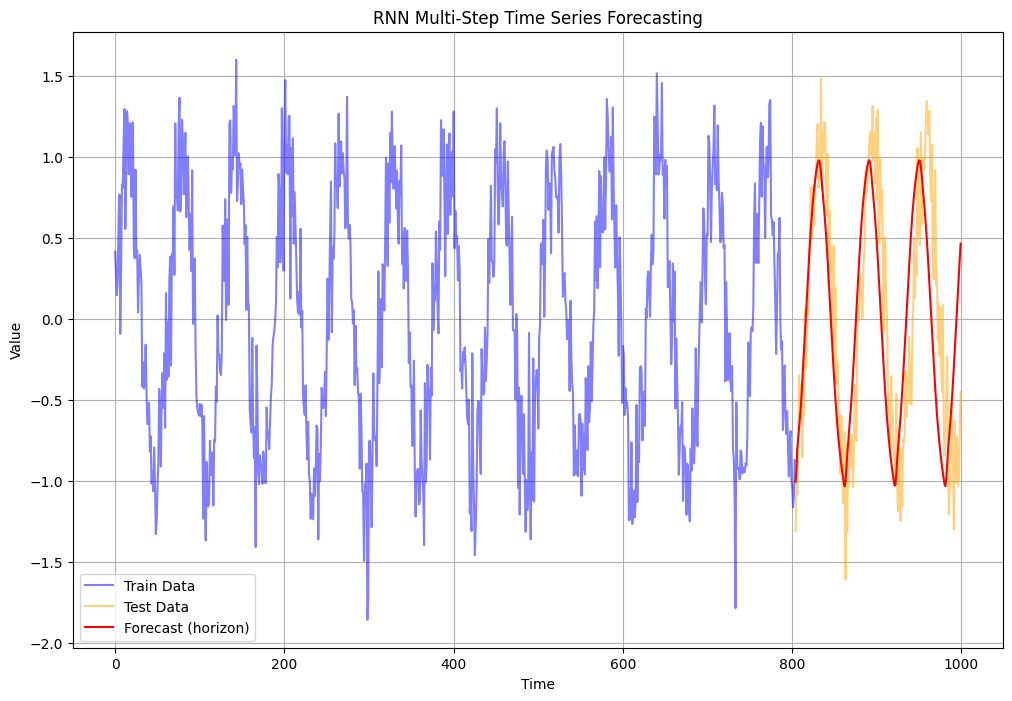

In [98]:
# Define the forecast horizon (number of steps to predict)
horizon = len(y_test)  # Forecast the entire test set

# Use the first test sequence as the initial input
test_sequence = torch.tensor(X_test[0], dtype=torch.float32)  # Shape: [seq_length]

# Perform multi-step forecasting
forecasted_values = multi_step_forecast(model, test_sequence, horizon)

# Plot the forecasted results
train_end_idx = len(X_train) + SEQ_LENGTH  # End of the training data
test_start_idx = len(X_train) + SEQ_LENGTH  # Start of the test data

plot_forecasts(
    time=np.arange(len(data)),  # Time indices
    data=data,                 # Original time series data
    train_end_idx=train_end_idx,
    test_start_idx=test_start_idx,
    forecasted_values=forecasted_values,
    title="RNN Multi-Step Time Series Forecasting"
)